# Сборный проект-4

Мы работаем в фотохостинге для профессиональных фотографов **«Со Смыслом» (“With Sense”)**. 
Пользователи размещают свои фотографии на хостинге и сопровождают их полным описанием: указывают место съёмок, модель камеры и т. д. Отличительная особенность сервиса — описание: его может предоставить не только тот, кто размещает фотографию, но и другие пользователи портала. 

Мы разрабатываем демонстрационную версию поиска изображений по запросу.

Для демонстрационной версии нужно обучить **модель**, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от **0 до 1** — покажет, насколько текст и картинка подходят друг другу.

## Описание

Загрузим и посмотрим на предоставленные данные.

### Загрузка

In [1]:
!pip install spacy -q
!python -m spacy download en_core_web_sm -q

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
      --------------------------------------- 0.3/12.8 MB ? eta -:--:--
     - ------------------------------------- 0.5/12.8 MB 985.5 kB/s eta 0:00:13
     -- ------------------------------------ 0.8/12.8 MB 987.4 kB/s eta 0:00:13
     -- ------------------------------------ 0.8/12.8 MB 987.4 kB/s eta 0:00:13
     --- ----------------------------------- 1.0/12.8 MB 967.3 kB/s eta 0:00:13
     --- ----------------------------------- 1.3/12.8 MB 919.0 kB/s eta 0:00:13
     ---- ---------------------------------- 1.6/12.8 MB 953.2 kB/s eta 0:00:12
     ----- --------------------------------- 1.8/12.8 MB 996.7 kB/s eta 0:00:12
     ------ --------------------------------- 2.1/12.8 MB 1.1 MB/s eta 0:00:11


In [2]:
!pip install open-clip-torch -q

In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

import os
import re
import spacy
import zipfile

from scipy.sparse import hstack

from transformers import BertTokenizer, BertModel

import torch
import open_clip
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torchvision import transforms
from scipy.sparse import hstack

from PIL import Image
from tensorflow.keras.utils import image_dataset_from_directory

from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics.pairwise import cosine_similarity

from tqdm.auto import tqdm

warnings.filterwarnings("ignore", category=FutureWarning)

<img src="https://emojigraph.org/media/apple/check-mark-button_2705.png" align=left width=33, heigth=33>
<div class="alert alert-success">
Отлично, все нужные библиотеки импортированы в начале ноутбука.Это хорошая практика.</div>

In [4]:
 def data_desc_info(data):
    try:
        print('')
        display('Первые 10 строк:')
        display(data.head(10))
        print('')
        print('')
        display('Общая информацию о датафрейме')
        data.info()
        print('')
        print('')
        display('Описание данных:')
        display(data.describe(include = "all"))
        print('')
        print('')
        display('Количество пропусков')
        display(data.isna().sum())
        print('')
    except:
        return 'Проверьте параметры'

<img src="https://upload.wikimedia.org/wikipedia/commons/b/ba/Warning_sign_4.0.png" align=left width=44, heigth=33>
<div class="alert alert-warning">
А вот оборачивать результат работы метода  .info() в функцию print() или display() это лишнее. Метод  info() и сам напечатает тебе нужную информацию. А вот через print()/display() ты выводишь только то,что данный метод возвращает - т.е. None
</div>

<div class="alert" style="background-color:#ead7f7;color:#8737bf">
    <font size="3"><b>Комментарий студента 1</b></font><br>
Убрала
</div>

<img src="https://emojigraph.org/media/apple/check-mark-button_2705.png" align=left width=33, heigth=33>
<div class="alert alert-success">
    <b>v2</b> 👍 </div>

Откроем датасет содержащий названия файлов и соответствующее фото. Для обращения к файлам зададим переменную *path* содержащую путь к папке.

In [5]:
path = 'to_upload'

<img src="https://emojigraph.org/media/apple/check-mark-button_2705.png" align=left width=33, heigth=33>
<div class="alert alert-success">
Большое тебе человеческое спасибо за вынос пути к данным в отдельную константу. Это сэкономило мне немало времени при проверке.</div>

#### train_dataset

In [6]:
train_dataset = pd.read_csv(f"{path}/train_dataset.csv")

data_desc_info(train_dataset)

'Первые 10 строк:'

,image,query_id,query_text
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
5,3030566410_393c36a6c5.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
6,3155451946_c0862c70cb.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
7,3222041930_f642f49d28.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
8,343218198_1ca90e0734.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
9,3718964174_cb2dc1615e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...


'Общая информацию о датафрейме'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB




'Описание данных:'

,image,query_id,query_text
count,5822,5822,5822
unique,1000,977,977
top,3364151356_eecd07a23e.jpg,2600867924_cd502fc911.jpg#2,"Two dogs , one brown and white and one black a..."
freq,10,34,34


'Количество пропусков'

image         0
query_id      0
query_text    0
dtype: int64

В файле ***train_dataset.csv*** находится информация, необходимая для обучения: 
* имя файла изображения
* идентификатор описания
* текст описания.

Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат <имя файла изображения>#<порядковый номер описания>.

<img src="https://emojigraph.org/media/apple/check-mark-button_2705.png" align=left width=33, heigth=33>
<div class="alert alert-success">
 👍 </div>

#### test_queries

In [7]:
test_queries = pd.read_csv(f"{path}/test_queries.csv", sep='|', index_col=0)

data_desc_info(test_queries)

'Первые 10 строк:'

,query_id,query_text,image
0,1177994172_10d143cb8d.jpg#0,"Two blonde boys , one in a camouflage shirt an...",1177994172_10d143cb8d.jpg
1,1177994172_10d143cb8d.jpg#1,Two boys are squirting water guns at each other .,1177994172_10d143cb8d.jpg
2,1177994172_10d143cb8d.jpg#2,Two boys spraying each other with water,1177994172_10d143cb8d.jpg
3,1177994172_10d143cb8d.jpg#3,Two children wearing jeans squirt water at eac...,1177994172_10d143cb8d.jpg
4,1177994172_10d143cb8d.jpg#4,Two young boys are squirting water at each oth...,1177994172_10d143cb8d.jpg
5,1232148178_4f45cc3284.jpg#0,A baby girl playing at a park .,1232148178_4f45cc3284.jpg
6,1232148178_4f45cc3284.jpg#1,A closeup of a child on a playground with adul...,1232148178_4f45cc3284.jpg
7,1232148178_4f45cc3284.jpg#2,A young boy poses for a picture in front of a ...,1232148178_4f45cc3284.jpg
8,1232148178_4f45cc3284.jpg#3,A young girl is smiling in front of the camera...,1232148178_4f45cc3284.jpg
9,1232148178_4f45cc3284.jpg#4,There is a little blond hair girl with a green...,1232148178_4f45cc3284.jpg


'Общая информацию о датафрейме'

<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   query_id    500 non-null    object
 1   query_text  500 non-null    object
 2   image       500 non-null    object
dtypes: object(3)
memory usage: 15.6+ KB




'Описание данных:'

,query_id,query_text,image
count,500,500,500
unique,500,500,100
top,1177994172_10d143cb8d.jpg#0,"Two blonde boys , one in a camouflage shirt an...",1177994172_10d143cb8d.jpg
freq,1,1,5


'Количество пропусков'

query_id      0
query_text    0
image         0
dtype: int64

В файле ***test_queries.csv*** находится информация, необходимая для тестирования: 
* идентификатор запроса
* текст запроса
* релевантное изображение

Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат <имя файла изображения>#<порядковый номер описания>.

<img src="https://emojigraph.org/media/apple/check-mark-button_2705.png" align=left width=33, heigth=33>
<div class="alert alert-success">
Если внимательно посмотреть на даные, то окажется что в тестовом датасете для каждого изображения есть 5 "родных" описаний, т.е. все пары изображение/описание идеально подходят друг другу. </div>

#### test_queries

In [8]:
test_images = pd.read_csv(f"{path}/test_images.csv")

data_desc_info(test_images)

'Первые 10 строк:'

,image
0,3356748019_2251399314.jpg
1,2887171449_f54a2b9f39.jpg
2,3089107423_81a24eaf18.jpg
3,1429546659_44cb09cbe2.jpg
4,1177994172_10d143cb8d.jpg
5,424307754_1e2f44d265.jpg
6,3044359043_627488ddf0.jpg
7,3396275223_ee080df8b5.jpg
8,2977379863_2e8d7a104e.jpg
9,634891010_9fa189effb.jpg


'Общая информацию о датафрейме'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   100 non-null    object
dtypes: object(1)
memory usage: 928.0+ bytes




'Описание данных:'

,image
count,100
unique,100
top,3356748019_2251399314.jpg
freq,1


'Количество пропусков'

image    0
dtype: int64

Таблица ***test_images*** содержит 100 имен изображений. Это те же уникальные изображения из датасета test_queries.

<img src="https://emojigraph.org/media/apple/check-mark-button_2705.png" align=left width=33, heigth=33>
<div class="alert alert-success">
 👍 </div>

#### CrowdAnnotations

In [9]:
crowd_annotations_df = pd.read_csv(f"{path}/CrowdAnnotations.tsv", sep='\t', header=None)

data_desc_info(crowd_annotations_df)

'Первые 10 строк:'

,0,1,2,3,4
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1.000000,3,0
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0.000000,0,3
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,0.000000,0,3
3,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,0.000000,0,3
4,1056338697_4f7d7ce270.jpg,2083434441_a93bc6306b.jpg#2,0.000000,0,3
5,1056338697_4f7d7ce270.jpg,2204550058_2707d92338.jpg#2,0.000000,0,3
6,1056338697_4f7d7ce270.jpg,2224450291_4c133fabe8.jpg#2,0.000000,0,3
7,1056338697_4f7d7ce270.jpg,2248487950_c62d0c81a9.jpg#2,0.333333,1,2
8,1056338697_4f7d7ce270.jpg,2307118114_c258e3a47e.jpg#2,0.000000,0,3
9,1056338697_4f7d7ce270.jpg,2309860995_c2e2a0feeb.jpg#2,0.000000,0,3


'Общая информацию о датафрейме'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       47830 non-null  object 
 1   1       47830 non-null  object 
 2   2       47830 non-null  float64
 3   3       47830 non-null  int64  
 4   4       47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB




'Описание данных:'

,0,1,2,3,4
count,47830,47830,47830.000000,47830.000000,47830.000000
unique,1000,1000,NaN,NaN,NaN
top,1572532018_64c030c974.jpg,249394748_2e4acfbbb5.jpg#2,NaN,NaN,NaN
freq,120,169,NaN,NaN,NaN
mean,NaN,NaN,0.068786,0.208488,2.820155
std,NaN,NaN,0.207532,0.628898,0.656676
min,NaN,NaN,0.000000,0.000000,0.000000
25%,NaN,NaN,0.000000,0.000000,3.000000
50%,NaN,NaN,0.000000,0.000000,3.000000
75%,NaN,NaN,0.000000,0.000000,3.000000


'Количество пропусков'

0    0
1    0
2    0
3    0
4    0
dtype: int64

<img src="https://upload.wikimedia.org/wikipedia/commons/b/ba/Warning_sign_4.0.png" align=left width=44, heigth=33>
<div class="alert alert-warning">
Обрати внимание, что название CrowdAnnotations_df не соответствует стандарту PEP8. В соответствии с этим стандартом называния для обычных переменных, функций и методов используется snake_case, а для названия классов используется CamelCase.  А в этом названии у тебя получилась какая-то причудливая смесь.
</div>

<div class="alert" style="background-color:#ead7f7;color:#8737bf">
    <font size="3"><b>Комментарий студента 1</b></font><br>
Спасибо, поправила
</div>

In [10]:
column_mapping = {
    0: 'image',
    1: 'query_id',
    2: 'confirm_ratio',
    3: 'confirm_num',
    4: 'not_confirm_num'
}

crowd_annotations_df = crowd_annotations_df.rename(columns = column_mapping)
crowd_annotations_df.head(1)

,image,query_id,confirm_ratio,confirm_num,not_confirm_num
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1.0,3,0


В файле ***CrowdAnnotations.tsv*** — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.
3. Доля людей, подтвердивших, что описание соответствует изображению.
4. Количество человек, подтвердивших, что описание соответствует изображению.
5. Количество человек, подтвердивших, что описание не соответствует изображению.

<img src="https://emojigraph.org/media/apple/check-mark-button_2705.png" align=left width=33, heigth=33>
<div class="alert alert-success">
 👍 </div>

#### ExpertAnnotations

In [11]:
expert_annotations_df = pd.read_csv(f"{path}/ExpertAnnotations.tsv", sep='\t', header=None)

data_desc_info(expert_annotations_df)

'Первые 10 строк:'

,0,1,2,3,4
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2
5,1056338697_4f7d7ce270.jpg,3360930596_1e75164ce6.jpg#2,1,1,1
6,1056338697_4f7d7ce270.jpg,3545652636_0746537307.jpg#2,1,1,1
7,1056338697_4f7d7ce270.jpg,434792818_56375e203f.jpg#2,1,1,2
8,106490881_5a2dd9b7bd.jpg,1425069308_488e5fcf9d.jpg#2,1,1,1
9,106490881_5a2dd9b7bd.jpg,1714316707_8bbaa2a2ba.jpg#2,2,2,2


'Общая информацию о датафрейме'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       5822 non-null   object
 1   1       5822 non-null   object
 2   2       5822 non-null   int64 
 3   3       5822 non-null   int64 
 4   4       5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.5+ KB




'Описание данных:'

,0,1,2,3,4
count,5822,5822,5822.000000,5822.000000,5822.000000
unique,1000,977,NaN,NaN,NaN
top,3107513635_fe8a21f148.jpg,2600867924_cd502fc911.jpg#2,NaN,NaN,NaN
freq,10,34,NaN,NaN,NaN
mean,NaN,NaN,1.436620,1.624356,1.881999
std,NaN,NaN,0.787084,0.856222,0.904087
min,NaN,NaN,1.000000,1.000000,1.000000
25%,NaN,NaN,1.000000,1.000000,1.000000
50%,NaN,NaN,1.000000,1.000000,2.000000
75%,NaN,NaN,2.000000,2.000000,2.000000


'Количество пропусков'

0    0
1    0
2    0
3    0
4    0
dtype: int64

In [12]:
column_mapping = {
    0: 'image',
    1: 'query_id',
    2: 'expert_1',
    3: 'expert_2',
    4: 'expert_3'
}

expert_annotations_df = expert_annotations_df.rename(columns = column_mapping)
expert_annotations_df.head(1)

,image,query_id,expert_1,expert_2,expert_3
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1


В файле ***ExpertAnnotations.tsv*** содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.
3. 3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 
* 1 — изображение и запрос совершенно не соответствуют друг другу
* 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует
* 3 — запрос и текст соответствуют с точностью до некоторых деталей
* 4 — запрос и текст соответствуют полностью.

<img src="https://emojigraph.org/media/apple/check-mark-button_2705.png" align=left width=33, heigth=33>
<div class="alert alert-success">
 Еще можешь обратить внимание, что в датафрейм с экспертными оценками и датафрейм train_dataset содержат одни и те же пары изображение/описание. </div>

Выведем несколько изображений из обучающей и тестовой выборок

In [13]:
train_images_df = image_dataset_from_directory(
    path + '/train_images',
    labels=None,
    label_mode="int",
    image_size=(256, 256),
    batch_size=32,
    shuffle=True,
    seed=42
)

Found 1000 files belonging to 1 classes.


In [14]:
file_paths = train_images_df.file_paths

for file_name in file_paths[:15]:
    print(file_name)

to_upload/train_images\3113322995_13781860f2.jpg
to_upload/train_images\3484832904_08619300d9.jpg
to_upload/train_images\3494394662_3edfd4a34c.jpg
to_upload/train_images\3350786891_6d39b234e9.jpg
to_upload/train_images\2891617125_f939f604c7.jpg
to_upload/train_images\3384314832_dffc944152.jpg
to_upload/train_images\326456451_effadbbe49.jpg
to_upload/train_images\3100251515_c68027cc22.jpg
to_upload/train_images\3708177171_529bb4ff1d.jpg
to_upload/train_images\2140182410_8e2a06fbda.jpg
to_upload/train_images\3597326009_3678a98a43.jpg
to_upload/train_images\1561658940_a947f2446a.jpg
to_upload/train_images\3294209955_a1f1e2cc19.jpg
to_upload/train_images\745880539_cd3f948837.jpg
to_upload/train_images\512101751_05a6d93e19.jpg


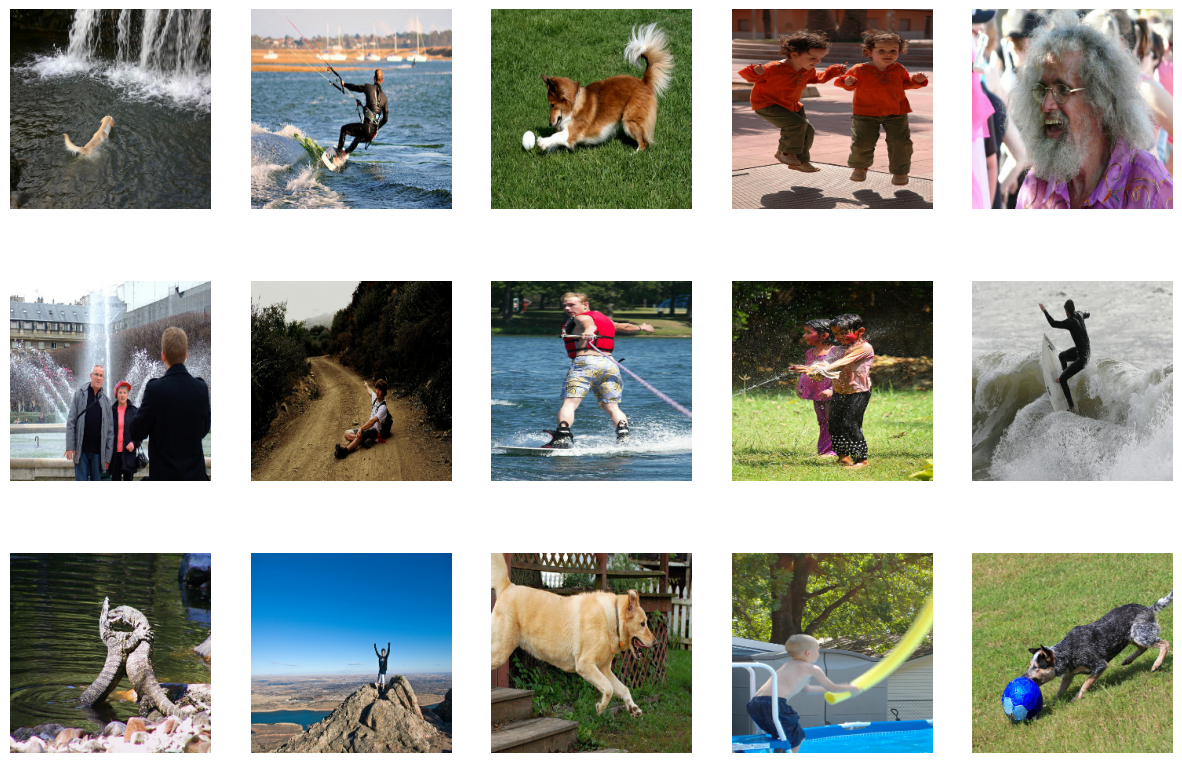

In [15]:
for image in train_images_df.take(1):
    
    plt.figure(figsize=(15, 10))
    for i in range(15):
        plt.subplot(3, 5, i + 1)
        plt.imshow(image[i].numpy().astype("uint8"))
        plt.axis("off")
    plt.show()

<img src="https://emojigraph.org/media/apple/check-mark-button_2705.png" align=left width=33, heigth=33>
<div class="alert alert-success">
 да, на картинки входящие в датасет тоже важно посмотреь.


что касается исползованнного image_dataset_from_directory - возможно это "стрельба из пушки по воробьям", т.к. таких простых операций как "прочитать изображение с диска и показать его" есть более простые инструменты, не являющиеся фреймворками для глубокого обучения.
    
-----------
    
Учитывая что для нейонок в этом проекте ты используешь pytorch, считаю использование keras для вывода изображений избыточным. Можно попробовать обойтись связкой os и PIL https://pillow.readthedocs.io/en/stable/handbook/tutorial.html    
</div>

### Вывод

* **train_dataset** — содержит 5822 записей, они относятся к 1000 уникальным изображениям, судя по столбцу image. У каждого изображения может быть до 5 описаний. query_id содержит идентификатор описания, query_text его содержимое текст. Уникальных описаний 922. Одно уникальное описание может относиться к разным изображениям.

* **test_queries**  — содержит 500 записей, где на 1 изображение имеется 5 записей с его описанием, пронумерованных от 1 до 5.

* **test_images** — список уникальных изображений для тестовой выборки.

* **CrowdAnnotations** — 47830 оценок описаний для изображений взятых с краудсорсиногового сервиса. Первые 2 квантиля доли согласных с описанием равны 0, значит большинство описаний не соответствуют изображению.

* **ExpertAnnotations** — 5822 оценок описаний с оценкой 3х экспертов. Медиана 1 и 2 эксперта в 1, они чаще не согласны с описанием. Медиана 3го эксперта на оценке 2.

### Исследовательский анализ

## Предобработка

Наша модель должна на выходе возвращать вероятность соответствия изображения тексту от 0 до 1. Будем решать задачу регрессии. 

Для получения этого числа - целевого признака используем данные оценки экспертов и сочетаем ее с оценкой не экспертов - краудсорсинга. Агрегируем в одну оценку от 0 до 1.

In [16]:
expert_annotations_df[4580:4601:1]

,image,query_id,expert_1,expert_2,expert_3
4580,3568197730_a071d7595b.jpg,2830869109_c4e403eae6.jpg#2,1,1,1
4581,3568197730_a071d7595b.jpg,2831217847_555b2f95ca.jpg#2,1,1,1
4582,3568197730_a071d7595b.jpg,2910758605_73a3f5a5c2.jpg#2,1,2,2
4583,3568197730_a071d7595b.jpg,3220650628_4ed964e5b4.jpg#2,1,1,1
4584,3568197730_a071d7595b.jpg,3432550415_e7b77232de.jpg#2,1,1,2
4585,3568197730_a071d7595b.jpg,3640422448_a0f42e4559.jpg#2,1,1,2
4586,3569406219_f37ebf7b92.jpg,1287073593_f3d2a62455.jpg#2,1,1,1
4587,3569406219_f37ebf7b92.jpg,241031254_0c6f30e3d1.jpg#2,1,1,1
4588,3569406219_f37ebf7b92.jpg,3027397797_4f1d305ced.jpg#2,1,2,2
4589,3569406219_f37ebf7b92.jpg,3197981073_3156963446.jpg#2,1,2,2


Найдем число записей, где есть оценки и 1 и 4:

In [17]:
mask_1 = expert_annotations_df.loc[:, ['expert_1', 'expert_2', 'expert_3']].isin([1]).any(axis=1)
mask_2 = expert_annotations_df.loc[:, ['expert_1', 'expert_2', 'expert_3']].isin([4]).any(axis=1)

mask_all = expert_annotations_df[mask_1 & mask_2]

mask_all.shape[0]

3

<img src="https://emojigraph.org/media/apple/check-mark-button_2705.png" align=left width=33, heigth=33>
<div class="alert alert-success">
думаю стоит посмотреть эти записи. возможно один эксперт просто ошибся?  </div>

In [18]:
print('Процент оценок 4-полностью соответствует:',100 * mask_2.sum()/expert_annotations_df.shape[0])

Процент оценок 4-полностью соответствует: 7.093782205427688


In [19]:
crowd_annotations_df.sort_values(by='query_id').head(10)

,image,query_id,confirm_ratio,confirm_num,not_confirm_num
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1.0,3,0
19920,2892995070_39f3c9a56e.jpg,1056338697_4f7d7ce270.jpg#2,0.0,0,3
6920,2182488373_df73c7cc09.jpg,1056338697_4f7d7ce270.jpg#2,0.0,0,3
29060,3250695024_93e8ab7305.jpg,1056338697_4f7d7ce270.jpg#2,0.0,0,3
14680,2594042571_2e4666507e.jpg,1056338697_4f7d7ce270.jpg#2,0.0,0,3
24750,311146855_0b65fdb169.jpg,1056338697_4f7d7ce270.jpg#2,0.0,0,3
39020,3605676864_0fb491267e.jpg,1056338697_4f7d7ce270.jpg#2,0.0,0,3
27760,3218480482_66af7587c8.jpg,1056338697_4f7d7ce270.jpg#2,0.0,0,3
29370,3256275785_9c3af57576.jpg,1056338697_4f7d7ce270.jpg#2,0.0,0,3
18730,2843695880_eeea6c67db.jpg,1056338697_4f7d7ce270.jpg#2,0.0,0,3


In [20]:
crowd_annotations_df[crowd_annotations_df['confirm_ratio'] >= 0.5].count()

image              2731
query_id           2731
confirm_ratio      2731
confirm_num        2731
not_confirm_num    2731
dtype: int64

Всего 2731 записей содержат долю согласных с описанием, где доля больше половины опрошенных.

Агрегируем оценки и создадим новый столбец target_proba. Это будет целевой признак для нашей модели. Для этого объединим датасеты по query_id.


In [21]:
expert_annotations_df.columns

Index(['image', 'query_id', 'expert_1', 'expert_2', 'expert_3'], dtype='object')

In [22]:
crowd_annotations_df.columns

Index(['image', 'query_id', 'confirm_ratio', 'confirm_num', 'not_confirm_num'], dtype='object')

In [23]:
# объединим таблицы по изображению и описанию
annotations_df = expert_annotations_df.merge(
    crowd_annotations_df,
    on=['image', 'query_id'],
    how='outer'
    )

data_desc_info(annotations_df)

'Первые 10 строк:'

,image,query_id,expert_1,expert_2,expert_3,confirm_ratio,confirm_num,not_confirm_num
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,NaN,NaN,NaN,1.000000,3.0,0.0
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,NaN,NaN,NaN,0.000000,0.0,3.0
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,NaN,NaN,NaN,0.000000,0.0,3.0
3,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,NaN,NaN,NaN,0.000000,0.0,3.0
4,1056338697_4f7d7ce270.jpg,2083434441_a93bc6306b.jpg#2,NaN,NaN,NaN,0.000000,0.0,3.0
5,1056338697_4f7d7ce270.jpg,2204550058_2707d92338.jpg#2,NaN,NaN,NaN,0.000000,0.0,3.0
6,1056338697_4f7d7ce270.jpg,2224450291_4c133fabe8.jpg#2,NaN,NaN,NaN,0.000000,0.0,3.0
7,1056338697_4f7d7ce270.jpg,2248487950_c62d0c81a9.jpg#2,NaN,NaN,NaN,0.333333,1.0,2.0
8,1056338697_4f7d7ce270.jpg,2307118114_c258e3a47e.jpg#2,NaN,NaN,NaN,0.000000,0.0,3.0
9,1056338697_4f7d7ce270.jpg,2309860995_c2e2a0feeb.jpg#2,NaN,NaN,NaN,0.000000,0.0,3.0


'Общая информацию о датафрейме'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51323 entries, 0 to 51322
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   image            51323 non-null  object 
 1   query_id         51323 non-null  object 
 2   expert_1         5822 non-null   float64
 3   expert_2         5822 non-null   float64
 4   expert_3         5822 non-null   float64
 5   confirm_ratio    47830 non-null  float64
 6   confirm_num      47830 non-null  float64
 7   not_confirm_num  47830 non-null  float64
dtypes: float64(6), object(2)
memory usage: 3.1+ MB




'Описание данных:'

,image,query_id,expert_1,expert_2,expert_3,confirm_ratio,confirm_num,not_confirm_num
count,51323,51323,5822.000000,5822.000000,5822.000000,47830.000000,47830.000000,47830.000000
unique,1000,1000,NaN,NaN,NaN,NaN,NaN,NaN
top,1572532018_64c030c974.jpg,249394748_2e4acfbbb5.jpg#2,NaN,NaN,NaN,NaN,NaN,NaN
freq,123,176,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,1.436620,1.624356,1.881999,0.068786,0.208488,2.820155
std,NaN,NaN,0.787084,0.856222,0.904087,0.207532,0.628898,0.656676
min,NaN,NaN,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,NaN,NaN,1.000000,1.000000,1.000000,0.000000,0.000000,3.000000
50%,NaN,NaN,1.000000,1.000000,2.000000,0.000000,0.000000,3.000000
75%,NaN,NaN,2.000000,2.000000,2.000000,0.000000,0.000000,3.000000


'Количество пропусков'

image                  0
query_id               0
expert_1           45501
expert_2           45501
expert_3           45501
confirm_ratio       3493
confirm_num         3493
not_confirm_num     3493
dtype: int64

In [24]:
annotations_df.duplicated().sum()

0

Создадим функцию aggregation_scores. Функция:
1. сумму оценок экспертов, домножит на коэффициент 0.6, так как мы доверяем экспертам больше. Оценку краудсорсинга мы возьмем из столбца confirm_ratio и умножим ее на коэффициент 0.4. Сложим результаты.
2. найдет минимум и максимум исходя из того, что минимум оценок экспертов 1+1+1=3, максимум 4+4+4=12. Минимальная доля подтвердивших из CrowdAnnotations_df = 0, а максимальная = 1.
3. вернет нормализованное значение target_proba, попадающее в диапазон [0,1].


\begin{equation}
\text{target\_proba} = \frac{
    \overbrace{0.6 \cdot (expert_1 + expert_2 + expert_3)}^{\text{Вклад экспертов}} + \overbrace{0.4 \cdot crowd_score}^{\text{Вклад краудсорсинга}} - \text{min\_score}
}{
    \text{max\_score} - \text{min\_score}
}
\end{equation}

где:
\begin{align*}
    & expert_1, expert_2, expert_3 \in \[1, 2, 3, 4\] \quad \text{(оценки экспертов)}, \\
    & crowd_score \in [0, 1] \quad \text{(доля подтверждения из \texttt{confirm\_ratio})}, \\
    & \text{min\_score} = 0.6 \cdot (1+1+1) + 0.4 \cdot 0 = 1.8, \\
    & \text{max\_score} = 0.6 \cdot (4+4+4) + 0.4 \cdot 1 = 7.6.
\end{align*}

<img src="https://emojigraph.org/media/apple/check-mark-button_2705.png" align=left width=33, heigth=33>
<div class="alert alert-success">
И пояснение и реализация на "высшем уровне"

Единственное, что сейчас у тебя экспертные оценки в диапазоне 1-4 и возможно стоило вначале привести их к диапазону 0-1, а уже затем применять взвешенное среднее.
    
Дело в том, что сейчас мы не очень хорошо понимаем, с какими пропорциями в итоговую оценку входят экспертная и крагауд оценки, т.к. диапазоны разные. 
    
Ну и код будет "полегче"    
</div>

In [25]:
def aggregation_scores(df):

    #
    if (pd.notna(df['expert_1'])) & (pd.notna(df['confirm_ratio'])):
        
        #
        sum_experts = (df['expert_1'] + df['expert_2'] + df['expert_3']) * 0.6
        crowd_score = df['confirm_ratio'] * 0.4
    
        #
        min_score = (1 + 1 + 1)*0.6 + (0 * 0.4)
        max_score = (4 + 4 + 4)*0.6 + (1 * 0.4)
    
        target_proba = ((sum_experts + crowd_score) - min_score)/(max_score - min_score)

    elif (pd.notna(df['expert_1'])) & (pd.isna(df['confirm_ratio'])):

        sum_experts = df['expert_1'] + df['expert_2'] + df['expert_3']

        min_score = 1 + 1 + 1
        max_score = 4 + 4 + 4

        target_proba = (sum_experts - min_score)/(max_score - min_score)
    
    elif (pd.isna(df['expert_1'])) & (pd.notna(df['confirm_ratio'])):

        target_proba = df['confirm_ratio']

    return target_proba

In [26]:
annotations_df['target_proba'] = annotations_df.apply(aggregation_scores, axis=1)

annotations_df.head(20)

,image,query_id,expert_1,expert_2,expert_3,confirm_ratio,confirm_num,not_confirm_num,target_proba
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,NaN,NaN,NaN,1.000000,3.0,0.0,1.000000
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,NaN,NaN,NaN,0.000000,0.0,3.0,0.000000
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,NaN,NaN,NaN,0.000000,0.0,3.0,0.000000
3,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,NaN,NaN,NaN,0.000000,0.0,3.0,0.000000
4,1056338697_4f7d7ce270.jpg,2083434441_a93bc6306b.jpg#2,NaN,NaN,NaN,0.000000,0.0,3.0,0.000000
5,1056338697_4f7d7ce270.jpg,2204550058_2707d92338.jpg#2,NaN,NaN,NaN,0.000000,0.0,3.0,0.000000
6,1056338697_4f7d7ce270.jpg,2224450291_4c133fabe8.jpg#2,NaN,NaN,NaN,0.000000,0.0,3.0,0.000000
7,1056338697_4f7d7ce270.jpg,2248487950_c62d0c81a9.jpg#2,NaN,NaN,NaN,0.333333,1.0,2.0,0.333333
8,1056338697_4f7d7ce270.jpg,2307118114_c258e3a47e.jpg#2,NaN,NaN,NaN,0.000000,0.0,3.0,0.000000
9,1056338697_4f7d7ce270.jpg,2309860995_c2e2a0feeb.jpg#2,NaN,NaN,NaN,0.000000,0.0,3.0,0.000000


In [27]:
#annotations_df.tail(50)

In [28]:
annotations_target_df = annotations_df[['image', 'query_id', 'target_proba']]

annotations_target_df.head(2)

,image,query_id,target_proba
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1.0
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0.0


In [29]:
train_dataset.duplicated().sum()

0

Чтобы получить текст описания по query_id соединим таблицу с train_dataset.

In [30]:
train_df = train_dataset.merge(
    annotations_target_df,
    on=['image', 'query_id'],
    how='outer'
    )

data_desc_info(train_df)

'Первые 10 строк:'

,image,query_id,query_text,target_proba
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,NaN,1.000000
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,NaN,0.000000
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,NaN,0.000000
3,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,NaN,0.000000
4,1056338697_4f7d7ce270.jpg,2083434441_a93bc6306b.jpg#2,NaN,0.000000
5,1056338697_4f7d7ce270.jpg,2204550058_2707d92338.jpg#2,NaN,0.000000
6,1056338697_4f7d7ce270.jpg,2224450291_4c133fabe8.jpg#2,NaN,0.000000
7,1056338697_4f7d7ce270.jpg,2248487950_c62d0c81a9.jpg#2,NaN,0.333333
8,1056338697_4f7d7ce270.jpg,2307118114_c258e3a47e.jpg#2,NaN,0.000000
9,1056338697_4f7d7ce270.jpg,2309860995_c2e2a0feeb.jpg#2,NaN,0.000000


'Общая информацию о датафрейме'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51323 entries, 0 to 51322
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   image         51323 non-null  object 
 1   query_id      51323 non-null  object 
 2   query_text    5822 non-null   object 
 3   target_proba  51323 non-null  float64
dtypes: float64(1), object(3)
memory usage: 1.6+ MB




'Описание данных:'

,image,query_id,query_text,target_proba
count,51323,51323,5822,51323.000000
unique,1000,1000,977,NaN
top,1572532018_64c030c974.jpg,249394748_2e4acfbbb5.jpg#2,"Two dogs , one brown and white and one black a...",NaN
freq,123,176,34,NaN
mean,NaN,NaN,NaN,0.078956
std,NaN,NaN,NaN,0.209995
min,NaN,NaN,NaN,0.000000
25%,NaN,NaN,NaN,0.000000
50%,NaN,NaN,NaN,0.000000
75%,NaN,NaN,NaN,0.000000


'Количество пропусков'

image               0
query_id            0
query_text      45501
target_proba        0
dtype: int64

Для каждого query_id существует 1 уникальное описание. Найдем его, и заполним пропуски в query_text.

In [31]:
# например, посмотрим на все записи об одном конкретном query_id
train_df[train_df['query_id']=='1056338697_4f7d7ce270.jpg#2']

,image,query_id,query_text,target_proba
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,NaN,1.0
7461,2182488373_df73c7cc09.jpg,1056338697_4f7d7ce270.jpg#2,NaN,0.0
15778,2594042571_2e4666507e.jpg,1056338697_4f7d7ce270.jpg#2,NaN,0.0
17018,2647049174_0fb47cee2e.jpg,1056338697_4f7d7ce270.jpg#2,"A woman is signaling is to traffic , as seen f...",0.0
20110,2843695880_eeea6c67db.jpg,1056338697_4f7d7ce270.jpg#2,NaN,0.0
21391,2892995070_39f3c9a56e.jpg,1056338697_4f7d7ce270.jpg#2,NaN,0.0
22589,2934359101_cdf57442dc.jpg,1056338697_4f7d7ce270.jpg#2,NaN,0.0
23446,2981702521_2459f2c1c4.jpg,1056338697_4f7d7ce270.jpg#2,NaN,0.0
26569,311146855_0b65fdb169.jpg,1056338697_4f7d7ce270.jpg#2,NaN,0.0
28988,3197981073_3156963446.jpg,1056338697_4f7d7ce270.jpg#2,NaN,0.0


In [32]:
#train_df[train_df['image']=='1056338697_4f7d7ce270.jpg']

In [33]:
query_df = train_df.dropna(subset='query_text') \
                   .sort_values(by='query_id') \
                   .groupby('query_id', as_index=False) \
                   .first() \
                   [['query_id','query_text']]

query_df.head(20)

,query_id,query_text
0,1056338697_4f7d7ce270.jpg#2,"A woman is signaling is to traffic , as seen f..."
1,106490881_5a2dd9b7bd.jpg#2,A young boy in swimming trunks is walking with...
2,1082379191_ec1e53f996.jpg#2,A man and a woman sitting on a dock .
3,1084040636_97d9633581.jpg#2,A white dog has its head on the ground .
4,1096395242_fc69f0ae5a.jpg#2,A young boy with his foot outstretched aims a ...
5,1107246521_d16a476380.jpg#2,A black dog pounces to get a rope toy .
6,1119015538_e8e796281e.jpg#2,A small dogs ears stick up as it runs in the g...
7,1122944218_8eb3607403.jpg#2,A baby wearing a white gown waves a Muslim flag .
8,1131800850_89c7ffd477.jpg#2,A furry dog attempts to dry itself by shaking ...
9,1131932671_c8d17751b3.jpg#2,A boy jumps from one bed to another .


In [34]:
query_df.shape[0]

977

In [35]:
train_df = train_df.merge(
    query_df,
    on='query_id',
    how='left'
)


train_df = train_df[['image', 'query_id', 'query_text_y', 'target_proba']]
train_df = train_df.rename(columns = {'query_text_y': 'query_text'})

data_desc_info(train_df)

'Первые 10 строк:'

,image,query_id,query_text,target_proba
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,"A woman is signaling is to traffic , as seen f...",1.000000
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,A boy in glasses is wearing a red shirt .,0.000000
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,A young boy holds onto a blue handle on a pier .,0.000000
3,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,"A woman wearing black clothes , a purple scarf...",0.000000
4,1056338697_4f7d7ce270.jpg,2083434441_a93bc6306b.jpg#2,An older woman with blond hair rides a bicycle...,0.000000
5,1056338697_4f7d7ce270.jpg,2204550058_2707d92338.jpg#2,A woman wearing a white glove peers over the c...,0.000000
6,1056338697_4f7d7ce270.jpg,2224450291_4c133fabe8.jpg#2,A man taking a picture with a silver camera .,0.000000
7,1056338697_4f7d7ce270.jpg,2248487950_c62d0c81a9.jpg#2,"A woman crosses the street near a man , who is...",0.333333
8,1056338697_4f7d7ce270.jpg,2307118114_c258e3a47e.jpg#2,A man wearing a black shirt and baseball cap s...,0.000000
9,1056338697_4f7d7ce270.jpg,2309860995_c2e2a0feeb.jpg#2,A woman wears sunglasses and a black coat as s...,0.000000


'Общая информацию о датафрейме'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51323 entries, 0 to 51322
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   image         51323 non-null  object 
 1   query_id      51323 non-null  object 
 2   query_text    50214 non-null  object 
 3   target_proba  51323 non-null  float64
dtypes: float64(1), object(3)
memory usage: 1.6+ MB




'Описание данных:'

,image,query_id,query_text,target_proba
count,51323,51323,50214,51323.000000
unique,1000,1000,977,NaN
top,1572532018_64c030c974.jpg,249394748_2e4acfbbb5.jpg#2,Two white dogs running,NaN
freq,123,176,176,NaN
mean,NaN,NaN,NaN,0.078956
std,NaN,NaN,NaN,0.209995
min,NaN,NaN,NaN,0.000000
25%,NaN,NaN,NaN,0.000000
50%,NaN,NaN,NaN,0.000000
75%,NaN,NaN,NaN,0.000000


'Количество пропусков'

image              0
query_id           0
query_text      1109
target_proba       0
dtype: int64

In [36]:
train_df = train_df.dropna()

### Вывод

Мы агрегировали оценку, взяв сумму оценок экспертов с коэффициентом 0.6 и долю согласных с описанием из краудсорсинга с коэффициентом 0.4. Сумму нормализировали и получили стобец target_proba целевое значение.

На данном этапе, наш тренировочный датасет содержит имя файла изображения, id описания. Мы добавили в него также текст описания и столбец с целевой переменной.

<img src="https://emojigraph.org/media/apple/check-mark-button_2705.png" align=left width=33, heigth=33>
<div class="alert alert-success">
Все ОК, предобработка завершена корректно, получен итоговый датафрейм признаки/таргет, с которым мы можем продолжить дальнейшую работу </div>

## 2. Проверка данных

В некоторых странах, где работает наша компания, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно тексты, изображения, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16 лет.

В нашем сервисе строго следуют законам стран, в которых работают. Поэтому при попытке посмотреть изображения, запрещённые законодательством, вместо картинок показывается дисклеймер:

> This image is unavailable in your country in compliance with local laws
>

Однако у нас в PoC нет возможности воспользоваться данным функционалом. Поэтому все изображения, которые нарушают данный закон, нужно удалить из обучающей выборки.

### 1.Cловарь слов относящихся к детям

Сначала создадим список слов, относящихся к детям. Если такие слова будут в описании, записи с ними мы удалим из выборки.

In [37]:
child_words = ['child',
               'baby',
               'newborn',
               'girl',
               'boy',
               #'daughter',
               #'son',
               'preschooler',
               'schoolboy',
               'schoolgirl',
               'teenager',
               'young',
               'youth',
               'minor',
               'juvenile',
               'toddler']

### 2. Лемматизация описаний

In [38]:
train_df['query_text_lower'] = train_df['query_text'].str.lower()

In [39]:
corpus = train_df['query_text_lower'].values.astype('U')

In [40]:
def clear_text(text):
    text = re.sub(r'[^a-zA-Z ]', ' ', text)
    return " ".join(text.split())

In [41]:
# !python -m spacy download en_core_web_sm

In [42]:
nlp = spacy.load("en_core_web_sm")

def lemmatize(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc])

In [43]:
print("Исходный текст:", corpus[66])
print("Очищенный и лемматизированный текст:", lemmatize(clear_text(corpus[66])))

Исходный текст: two little children and one is playing with a slinky .
Очищенный и лемматизированный текст: two little child and one be play with a slinky


In [44]:
tqdm.pandas()
train_clean_text_df = train_df.copy()

train_clean_text_df['query_text_cleaned'] = train_clean_text_df['query_text_lower'].progress_apply(clear_text)

100%|██████████| 50214/50214 [00:00<00:00, 429179.98it/s]


In [45]:
train_clean_text_df['query_text_lemmatized'] = train_clean_text_df['query_text_cleaned'].progress_apply(lemmatize)
train_clean_text_df.head(5)

100%|██████████| 50214/50214 [04:44<00:00, 176.44it/s]


,image,query_id,query_text,target_proba,query_text_lower,query_text_cleaned,query_text_lemmatized
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,"A woman is signaling is to traffic , as seen f...",1.0,"a woman is signaling is to traffic , as seen f...",a woman is signaling is to traffic as seen fro...,a woman be signal be to traffic as see from be...
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,A boy in glasses is wearing a red shirt .,0.0,a boy in glasses is wearing a red shirt .,a boy in glasses is wearing a red shirt,a boy in glass be wear a red shirt
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,A young boy holds onto a blue handle on a pier .,0.0,a young boy holds onto a blue handle on a pier .,a young boy holds onto a blue handle on a pier,a young boy hold onto a blue handle on a pier
3,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,"A woman wearing black clothes , a purple scarf...",0.0,"a woman wearing black clothes , a purple scarf...",a woman wearing black clothes a purple scarf a...,a woman wear black clothe a purple scarf and a...
4,1056338697_4f7d7ce270.jpg,2083434441_a93bc6306b.jpg#2,An older woman with blond hair rides a bicycle...,0.0,an older woman with blond hair rides a bicycle...,an older woman with blond hair rides a bicycle...,an old woman with blond hair ride a bicycle do...


Описания почищены от знаков препинания и лемматизированы с помощью WordNetLemmatizer().

### 3. Удаление строк

In [46]:
#train_clean_text_df[train_clean_text_df['target_proba']>0.5].head(10)

В датасете имена query_id созданы из имен image, для которых они были созданы. Для использования этих описаний для других изображений, им присваивались номера в виде комбинаци '#2'. Используем это:

* новый датафрейм создадим, удалив строки из train_df содержащие слова из словаря child_words
* включающие те строки, где 'image' = 'query_id'(часть до знака #)

In [47]:
train_clean_text_df['is_not_legal'] = train_clean_text_df['query_text_lemmatized'].apply(
    lambda x: 1 if any (word in x for word in child_words) else 0
)

train_clean_text_df.head(5)

,image,query_id,query_text,target_proba,query_text_lower,query_text_cleaned,query_text_lemmatized,is_not_legal
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,"A woman is signaling is to traffic , as seen f...",1.0,"a woman is signaling is to traffic , as seen f...",a woman is signaling is to traffic as seen fro...,a woman be signal be to traffic as see from be...,0
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,A boy in glasses is wearing a red shirt .,0.0,a boy in glasses is wearing a red shirt .,a boy in glasses is wearing a red shirt,a boy in glass be wear a red shirt,1
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,A young boy holds onto a blue handle on a pier .,0.0,a young boy holds onto a blue handle on a pier .,a young boy holds onto a blue handle on a pier,a young boy hold onto a blue handle on a pier,1
3,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,"A woman wearing black clothes , a purple scarf...",0.0,"a woman wearing black clothes , a purple scarf...",a woman wearing black clothes a purple scarf a...,a woman wear black clothe a purple scarf and a...,0
4,1056338697_4f7d7ce270.jpg,2083434441_a93bc6306b.jpg#2,An older woman with blond hair rides a bicycle...,0.0,an older woman with blond hair rides a bicycle...,an older woman with blond hair rides a bicycle...,an old woman with blond hair ride a bicycle do...,0


In [48]:
train_legal_df = train_clean_text_df.copy()

mask =  (train_legal_df['is_not_legal']==1) & \
        (train_legal_df['image'] == train_legal_df['query_id'].str[:-2])

train_legal_df = train_legal_df[~mask]

train_legal_df= train_legal_df.reset_index(drop=True)

data_desc_info(train_legal_df)

'Первые 10 строк:'

,image,query_id,query_text,target_proba,query_text_lower,query_text_cleaned,query_text_lemmatized,is_not_legal
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,"A woman is signaling is to traffic , as seen f...",1.000000,"a woman is signaling is to traffic , as seen f...",a woman is signaling is to traffic as seen fro...,a woman be signal be to traffic as see from be...,0
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,A boy in glasses is wearing a red shirt .,0.000000,a boy in glasses is wearing a red shirt .,a boy in glasses is wearing a red shirt,a boy in glass be wear a red shirt,1
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,A young boy holds onto a blue handle on a pier .,0.000000,a young boy holds onto a blue handle on a pier .,a young boy holds onto a blue handle on a pier,a young boy hold onto a blue handle on a pier,1
3,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,"A woman wearing black clothes , a purple scarf...",0.000000,"a woman wearing black clothes , a purple scarf...",a woman wearing black clothes a purple scarf a...,a woman wear black clothe a purple scarf and a...,0
4,1056338697_4f7d7ce270.jpg,2083434441_a93bc6306b.jpg#2,An older woman with blond hair rides a bicycle...,0.000000,an older woman with blond hair rides a bicycle...,an older woman with blond hair rides a bicycle...,an old woman with blond hair ride a bicycle do...,0
5,1056338697_4f7d7ce270.jpg,2204550058_2707d92338.jpg#2,A woman wearing a white glove peers over the c...,0.000000,a woman wearing a white glove peers over the c...,a woman wearing a white glove peers over the c...,a woman wear a white glove peer over the crowd,0
6,1056338697_4f7d7ce270.jpg,2224450291_4c133fabe8.jpg#2,A man taking a picture with a silver camera .,0.000000,a man taking a picture with a silver camera .,a man taking a picture with a silver camera,a man take a picture with a silver camera,0
7,1056338697_4f7d7ce270.jpg,2248487950_c62d0c81a9.jpg#2,"A woman crosses the street near a man , who is...",0.333333,"a woman crosses the street near a man , who is...",a woman crosses the street near a man who is o...,a woman cross the street near a man who be on ...,0
8,1056338697_4f7d7ce270.jpg,2307118114_c258e3a47e.jpg#2,A man wearing a black shirt and baseball cap s...,0.000000,a man wearing a black shirt and baseball cap s...,a man wearing a black shirt and baseball cap s...,a man wear a black shirt and baseball cap smile,0
9,1056338697_4f7d7ce270.jpg,2309860995_c2e2a0feeb.jpg#2,A woman wears sunglasses and a black coat as s...,0.000000,a woman wears sunglasses and a black coat as s...,a woman wears sunglasses and a black coat as s...,a woman wear sunglass and a black coat as she ...,0


'Общая информацию о датафрейме'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50007 entries, 0 to 50006
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   image                  50007 non-null  object 
 1   query_id               50007 non-null  object 
 2   query_text             50007 non-null  object 
 3   target_proba           50007 non-null  float64
 4   query_text_lower       50007 non-null  object 
 5   query_text_cleaned     50007 non-null  object 
 6   query_text_lemmatized  50007 non-null  object 
 7   is_not_legal           50007 non-null  int64  
dtypes: float64(1), int64(1), object(6)
memory usage: 3.1+ MB




'Описание данных:'

,image,query_id,query_text,target_proba,query_text_lower,query_text_cleaned,query_text_lemmatized,is_not_legal
count,50007,50007,50007,50007.000000,50007,50007,50007,50007.000000
unique,1000,977,977,NaN,977,977,977,NaN
top,1572532018_64c030c974.jpg,249394748_2e4acfbbb5.jpg#2,Two white dogs running,NaN,two white dogs running,two white dogs running,two white dog run,NaN
freq,117,176,176,NaN,176,176,176,NaN
mean,NaN,NaN,NaN,0.076411,NaN,NaN,NaN,0.287480
std,NaN,NaN,NaN,0.203973,NaN,NaN,NaN,0.452592
min,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,0.000000
25%,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,0.000000
50%,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,0.000000
75%,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,1.000000


'Количество пропусков'

image                    0
query_id                 0
query_text               0
target_proba             0
query_text_lower         0
query_text_cleaned       0
query_text_lemmatized    0
is_not_legal             0
dtype: int64

In [49]:
train_legal_df[(train_legal_df['target_proba']>0.6) & \
               (train_legal_df['is_not_legal']==1)]

,image,query_id,query_text,target_proba,query_text_lower,query_text_cleaned,query_text_lemmatized,is_not_legal
446,1122944218_8eb3607403.jpg,3325497914_f9014d615b.jpg#2,A woman holding a little girls hand is pointin...,0.666667,a woman holding a little girls hand is pointin...,a woman holding a little girls hand is pointin...,a woman hold a little girl hand be point to so...,1
544,1131932671_c8d17751b3.jpg,2461616306_3ee7ac1b4b.jpg#2,a boy jumps into the blue pool water .,0.666667,a boy jumps into the blue pool water .,a boy jumps into the blue pool water,a boy jump into the blue pool water,1
559,1131932671_c8d17751b3.jpg,3245460937_2710a82709.jpg#2,A child jumping on a tennis court .,0.689655,a child jumping on a tennis court .,a child jumping on a tennis court,a child jump on a tennis court,1
732,1174525839_7c1e6cfa86.jpg,1352410176_af6b139734.jpg#2,A young girl balances on wooden pylons at the ...,0.666667,a young girl balances on wooden pylons at the ...,a young girl balances on wooden pylons at the ...,a young girl balance on wooden pylon at the beach,1
734,1174525839_7c1e6cfa86.jpg,1408958345_68eea9a4e4.jpg#2,A little girl in a flower swimsuit running acr...,0.666667,a little girl in a flower swimsuit running acr...,a little girl in a flower swimsuit running acr...,a little girl in a flower swimsuit run across ...,1
...,...,...,...,...,...,...,...,...
49065,758921886_55a351dd67.jpg,444057017_f1e0fcaef7.jpg#2,A little girl on a piece of playground equipment,0.666667,a little girl on a piece of playground equipment,a little girl on a piece of playground equipment,a little girl on a piece of playground equipment,1
49068,758921886_55a351dd67.jpg,542317719_ed4dd95dc2.jpg#2,A smiling child slides down a slippery tube slide,0.977011,a smiling child slides down a slippery tube slide,a smiling child slides down a slippery tube slide,a smile child slide down a slippery tube slide,1
49508,909191414_1cf5d85821.jpg,2274992140_bb9e868bb8.jpg#2,Two little children and one is playing with a ...,0.666667,two little children and one is playing with a ...,two little children and one is playing with a ...,two little child and one be play with a slinky,1
49893,968081289_cdba83ce2e.jpg,3430607596_7e4f74e3ff.jpg#2,A boy takes a flying leap into the water .,0.666667,a boy takes a flying leap into the water .,a boy takes a flying leap into the water,a boy take a fly leap into the water,1


После первого фильтра удалено около 200 изображений. Однако изображения с описанием детей и оценкой 1 еще присутствуют. 

Возьмем теперь условие 'is_not_legal'==1 и оценка больше 0.6

In [50]:
mask_02 = (train_legal_df['target_proba']>0.6) & \
          (train_legal_df['is_not_legal']==1)

train_legal_df = train_legal_df[~mask_02]

train_legal_df= train_legal_df.reset_index(drop=True)

data_desc_info(train_legal_df)

'Первые 10 строк:'

,image,query_id,query_text,target_proba,query_text_lower,query_text_cleaned,query_text_lemmatized,is_not_legal
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,"A woman is signaling is to traffic , as seen f...",1.000000,"a woman is signaling is to traffic , as seen f...",a woman is signaling is to traffic as seen fro...,a woman be signal be to traffic as see from be...,0
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,A boy in glasses is wearing a red shirt .,0.000000,a boy in glasses is wearing a red shirt .,a boy in glasses is wearing a red shirt,a boy in glass be wear a red shirt,1
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,A young boy holds onto a blue handle on a pier .,0.000000,a young boy holds onto a blue handle on a pier .,a young boy holds onto a blue handle on a pier,a young boy hold onto a blue handle on a pier,1
3,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,"A woman wearing black clothes , a purple scarf...",0.000000,"a woman wearing black clothes , a purple scarf...",a woman wearing black clothes a purple scarf a...,a woman wear black clothe a purple scarf and a...,0
4,1056338697_4f7d7ce270.jpg,2083434441_a93bc6306b.jpg#2,An older woman with blond hair rides a bicycle...,0.000000,an older woman with blond hair rides a bicycle...,an older woman with blond hair rides a bicycle...,an old woman with blond hair ride a bicycle do...,0
5,1056338697_4f7d7ce270.jpg,2204550058_2707d92338.jpg#2,A woman wearing a white glove peers over the c...,0.000000,a woman wearing a white glove peers over the c...,a woman wearing a white glove peers over the c...,a woman wear a white glove peer over the crowd,0
6,1056338697_4f7d7ce270.jpg,2224450291_4c133fabe8.jpg#2,A man taking a picture with a silver camera .,0.000000,a man taking a picture with a silver camera .,a man taking a picture with a silver camera,a man take a picture with a silver camera,0
7,1056338697_4f7d7ce270.jpg,2248487950_c62d0c81a9.jpg#2,"A woman crosses the street near a man , who is...",0.333333,"a woman crosses the street near a man , who is...",a woman crosses the street near a man who is o...,a woman cross the street near a man who be on ...,0
8,1056338697_4f7d7ce270.jpg,2307118114_c258e3a47e.jpg#2,A man wearing a black shirt and baseball cap s...,0.000000,a man wearing a black shirt and baseball cap s...,a man wearing a black shirt and baseball cap s...,a man wear a black shirt and baseball cap smile,0
9,1056338697_4f7d7ce270.jpg,2309860995_c2e2a0feeb.jpg#2,A woman wears sunglasses and a black coat as s...,0.000000,a woman wears sunglasses and a black coat as s...,a woman wears sunglasses and a black coat as s...,a woman wear sunglass and a black coat as she ...,0


'Общая информацию о датафрейме'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49695 entries, 0 to 49694
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   image                  49695 non-null  object 
 1   query_id               49695 non-null  object 
 2   query_text             49695 non-null  object 
 3   target_proba           49695 non-null  float64
 4   query_text_lower       49695 non-null  object 
 5   query_text_cleaned     49695 non-null  object 
 6   query_text_lemmatized  49695 non-null  object 
 7   is_not_legal           49695 non-null  int64  
dtypes: float64(1), int64(1), object(6)
memory usage: 3.0+ MB




'Описание данных:'

,image,query_id,query_text,target_proba,query_text_lower,query_text_cleaned,query_text_lemmatized,is_not_legal
count,49695,49695,49695,49695.000000,49695,49695,49695,49695.000000
unique,1000,977,977,NaN,977,977,977,NaN
top,1572532018_64c030c974.jpg,249394748_2e4acfbbb5.jpg#2,Two white dogs running,NaN,two white dogs running,two white dogs running,two white dog run,NaN
freq,117,176,176,NaN,176,176,176,NaN
mean,NaN,NaN,NaN,0.072125,NaN,NaN,NaN,0.283006
std,NaN,NaN,NaN,0.196937,NaN,NaN,NaN,0.450464
min,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,0.000000
25%,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,0.000000
50%,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,0.000000
75%,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,1.000000


'Количество пропусков'

image                    0
query_id                 0
query_text               0
target_proba             0
query_text_lower         0
query_text_cleaned       0
query_text_lemmatized    0
is_not_legal             0
dtype: int64

После удаления из тренировочного датасета строк, где в описании изображений есть выделенные слова, а также оценка запретного описания выше 0.6, в нем осталось 49695 записей. Это хороший размер датасета.

## 3. Векторизация изображений

Перейдём к векторизации изображений.

Для обработки используем ResNet-18 сверточную нейросеть, обученную на 1000 классов, предобученную на датасете ImageNet.

Удалим слои, отвечающие за классификацию, так как нам нужно только извлечь признаки. При обучении модели заморозим веса по той же причине.

In [51]:
# Загрузим модель ResNet-18:
resnet = models.resnet18(pretrained=True)

C:\Users\User\anaconda3\envs\tf_gpu\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\tf_gpu\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [52]:
# Нам не потребуется обучать модель, поэтому рекомендуем заморозить веса:
for param in resnet.parameters():
    param.requires_grad_(False)

После заморозки весов надо определиться, все ли слои можно использовать для получения эмбеддингов. На практике используются только свёрточные слои.

In [53]:
print(list(resnet.children())) 

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False), BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), ReLU(inplace=True), MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False), Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bia

В нашем случае, нужно взять все слои, кроме последнего:

In [54]:
modules = list(resnet.children())[:-1]
resnet = nn.Sequential(*modules) 

In [55]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [56]:
#  перевести модель в режим предсказания
resnet.eval() 

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [57]:
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [58]:
class ImageDataset(Dataset):
    def __init__(self, image_paths, transform):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert('RGB')
        return self.transform(img)

In [59]:
path

'to_upload'

In [60]:
path_train = path + '/train_images/'

In [61]:
# Функция для загрузки изображения и преобразования в тензор
def load_image(path):
    img = Image.open(path).convert('RGB')
    return preprocess(img)

In [62]:
train_legal_df.head(3)

,image,query_id,query_text,target_proba,query_text_lower,query_text_cleaned,query_text_lemmatized,is_not_legal
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,"A woman is signaling is to traffic , as seen f...",1.0,"a woman is signaling is to traffic , as seen f...",a woman is signaling is to traffic as seen fro...,a woman be signal be to traffic as see from be...,0
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,A boy in glasses is wearing a red shirt .,0.0,a boy in glasses is wearing a red shirt .,a boy in glasses is wearing a red shirt,a boy in glass be wear a red shirt,1
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,A young boy holds onto a blue handle on a pier .,0.0,a young boy holds onto a blue handle on a pier .,a young boy holds onto a blue handle on a pier,a young boy hold onto a blue handle on a pier,1


In [63]:
image_paths = [os.path.join(path_train, fname) \
               for fname in os.listdir(path_train) \
               if fname.endswith((".jpg"))]

In [64]:
batch_size = 16

ImageDataset загружает и предобрабатывает изображения (например, до размера 224x224 и нормализует их для CLIP). DataLoader создаёт мини-батчи, чтобы не загружать все изображения в память сразу.

In [65]:
dataset = ImageDataset(image_paths, preprocess)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [66]:
features_list = []

In [67]:
# Отключаем градиенты
with torch.no_grad():  
    for batch in tqdm(dataloader, desc="Векторизация изображений", ncols=100, leave=True):
        # переносим на GPU
        batch = batch.to(device)  

        # преобразуем в векторы [N, 512], resnet18 дает 512 фич
        features = resnet(batch).view(batch.size(0), -1)  
        
        features_list.append(features.cpu())  # переносим в CPU для экономии GPU-памяти

Векторизация изображений: 100%|█████████████████████████████████████| 63/63 [00:13<00:00,  4.53it/s]


In [68]:
image_tensor = torch.cat(features_list)
print(f"Размер финального тензора: {image_tensor.shape}")

Размер финального тензора: torch.Size([1000, 512])


In [69]:
# # Сохраняем векторные представления
# torch.save(image_tensor, "image_features.pt")

Были векторизированы 1000 уникальных изображений. 

Создадим таблицу соответствующую 49695 тренировочным записям.

In [70]:
train_legal_df.head(3)

,image,query_id,query_text,target_proba,query_text_lower,query_text_cleaned,query_text_lemmatized,is_not_legal
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,"A woman is signaling is to traffic , as seen f...",1.0,"a woman is signaling is to traffic , as seen f...",a woman is signaling is to traffic as seen fro...,a woman be signal be to traffic as see from be...,0
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,A boy in glasses is wearing a red shirt .,0.0,a boy in glasses is wearing a red shirt .,a boy in glasses is wearing a red shirt,a boy in glass be wear a red shirt,1
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,A young boy holds onto a blue handle on a pier .,0.0,a young boy holds onto a blue handle on a pier .,a young boy holds onto a blue handle on a pier,a young boy hold onto a blue handle on a pier,1


In [71]:
image_paths

['to_upload/train_images/1056338697_4f7d7ce270.jpg',
 'to_upload/train_images/106490881_5a2dd9b7bd.jpg',
 'to_upload/train_images/1082379191_ec1e53f996.jpg',
 'to_upload/train_images/1084040636_97d9633581.jpg',
 'to_upload/train_images/1096395242_fc69f0ae5a.jpg',
 'to_upload/train_images/1107246521_d16a476380.jpg',
 'to_upload/train_images/1119015538_e8e796281e.jpg',
 'to_upload/train_images/1122944218_8eb3607403.jpg',
 'to_upload/train_images/1131800850_89c7ffd477.jpg',
 'to_upload/train_images/1131932671_c8d17751b3.jpg',
 'to_upload/train_images/113678030_87a6a6e42e.jpg',
 'to_upload/train_images/114051287_dd85625a04.jpg',
 'to_upload/train_images/115684808_cb01227802.jpg',
 'to_upload/train_images/1167669558_87a8a467d6.jpg',
 'to_upload/train_images/1174525839_7c1e6cfa86.jpg',
 'to_upload/train_images/1174629344_a2e1a2bdbf.jpg',
 'to_upload/train_images/1220401002_3f44b1f3f7.jpg',
 'to_upload/train_images/1224851143_33bcdd299c.jpg',
 'to_upload/train_images/1237985362_dbafc59280.jpg

In [72]:
image_names = []
path_begin = 'to_upload/train_images/'

image_names = [i.replace(path_begin, '') for i in image_paths]
len(image_names)

1000

In [73]:
image_names_df = pd.DataFrame(image_names)
image_names_df.head(3)

,0
0,1056338697_4f7d7ce270.jpg
1,106490881_5a2dd9b7bd.jpg
2,1082379191_ec1e53f996.jpg


In [74]:
image_indices = train_legal_df['image'].map(lambda x: image_names_df[image_names_df == x].index[0])
len(image_indices)

49695

In [75]:
image_vectors = image_tensor[torch.tensor(image_indices.values)]

### Вывод

Все изображения из train_legal_df векторизированы с помощью сверточной нейросети ResNet18. Датасет загружали батчами для обработки на графическом процессоре для оптимизации. Векторы вынесены в тензор.

## 4. Векторизация текстов

Следующий этап — векторизация текстов. Будем использовать BERT.


In [76]:
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# bert = BertModel.from_pretrained('bert-base-uncased')

In [77]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# переносим модель на GPU
bert = BertModel.from_pretrained('bert-base-uncased').to(device)

In [78]:
def get_bert_embbedding(text):
    
    tokens = tokenizer(text, 
                       padding='max_length', 
                       truncation=True, 
                       max_length=128, 
                       return_tensors='pt').to(device)

    with torch.no_grad():
        output = bert(**tokens)

    return output.last_hidden_state[:, 0, :].squeeze().cpu().numpy()

In [79]:
train_legal_df['query_embedding'] = train_legal_df['query_text_lemmatized'].progress_apply(get_bert_embbedding)

100%|██████████| 49695/49695 [10:00<00:00, 82.80it/s]


In [80]:
train_legal_df.head(5)

,image,query_id,query_text,target_proba,query_text_lower,query_text_cleaned,query_text_lemmatized,is_not_legal,query_embedding
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,"A woman is signaling is to traffic , as seen f...",1.0,"a woman is signaling is to traffic , as seen f...",a woman is signaling is to traffic as seen fro...,a woman be signal be to traffic as see from be...,0,"[-0.19789472, 0.2541251, 0.030726789, -0.22099..."
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,A boy in glasses is wearing a red shirt .,0.0,a boy in glasses is wearing a red shirt .,a boy in glasses is wearing a red shirt,a boy in glass be wear a red shirt,1,"[-0.08787605, 0.14255653, -0.23526181, 0.13513..."
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,A young boy holds onto a blue handle on a pier .,0.0,a young boy holds onto a blue handle on a pier .,a young boy holds onto a blue handle on a pier,a young boy hold onto a blue handle on a pier,1,"[0.2427854, 0.017120805, -0.29616824, -0.00344..."
3,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,"A woman wearing black clothes , a purple scarf...",0.0,"a woman wearing black clothes , a purple scarf...",a woman wearing black clothes a purple scarf a...,a woman wear black clothe a purple scarf and a...,0,"[-0.32963714, -0.0047769356, -0.6348282, 0.107..."
4,1056338697_4f7d7ce270.jpg,2083434441_a93bc6306b.jpg#2,An older woman with blond hair rides a bicycle...,0.0,an older woman with blond hair rides a bicycle...,an older woman with blond hair rides a bicycle...,an old woman with blond hair ride a bicycle do...,0,"[0.27987325, 0.19104153, -0.20368199, -0.01416..."


In [81]:
train_legal_df['query_embedding']

0        [-0.19789472, 0.2541251, 0.030726789, -0.22099...
1        [-0.08787605, 0.14255653, -0.23526181, 0.13513...
2        [0.2427854, 0.017120805, -0.29616824, -0.00344...
3        [-0.32963714, -0.0047769356, -0.6348282, 0.107...
4        [0.27987325, 0.19104153, -0.20368199, -0.01416...
                               ...                        
49690    [-0.45506188, -0.2254789, -0.823685, 0.1492770...
49691    [-0.25995395, -0.093175516, -0.27633193, 0.346...
49692    [-0.2187889, 0.54313284, -0.56599826, -0.05850...
49693    [-0.3340526, 0.10926746, -0.32628733, 0.084387...
49694    [-0.46375456, 0.13644257, -0.15476742, -0.0143...
Name: query_embedding, Length: 49695, dtype: object

## 5. Объединение векторов

Для подачи данных в модели, объединим векторы.

In [82]:
# текстовые векторы из разреженной матрицы
query_vectors = np.vstack(train_legal_df['query_embedding'].values)
query_vectors.shape

(49695, 768)

In [83]:
X = np.hstack((image_vectors, query_vectors))

X.shape

(49695, 1280)

In [84]:
y = train_legal_df['target_proba'].values

y.shape

(49695,)

<img src="https://emojigraph.org/media/apple/check-mark-button_2705.png" align=left width=33, heigth=33>
<div class="alert alert-success">
 Вектора, полученные из текста и изображения объеденены👍 </div>

## 6. Обучение модели предсказания соответствия

Для обучения разделим датасет на тренировочную и тестовую выборки. 

Простое случайное разбиение не подходит: нужно исключить попадание изображения **и в обучающую, и в тестовую выборки**.
Для этого воспомльзуемся классом GroupShuffleSplit из библиотеки sklearn.model_selection.

In [85]:
# тренировочную и валидационная выборки в пропорции 7:3
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)

In [86]:
# строки с одинаковым значением 'group_column' не будут пересекаться в выборках
# а будут находиться только в train или только в val
train_indices, val_indices = next(gss.split(X = X, 
                                            y = y, 
                                            groups = train_legal_df['image']))

<img src="https://emojigraph.org/media/apple/check-mark-button_2705.png" align=left width=33, heigth=33>
<div class="alert alert-success">
Отлично, благодаря использованию GroupShuffleSplit ты исключаешь попадание одного изображения в обучающий и валидационный наборы.</div>

In [87]:
X_train, X_val = X[train_indices], X[val_indices]
y_train, y_val = y[train_indices], y[val_indices]

In [88]:
display(X_train.shape)
display(X_val.shape)

display(y_train.shape)
display(y_val.shape)

(34618, 1280)

(15077, 1280)

(34618,)

(15077,)

In [89]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)

Для сравнения предсказаний с реальными данными будем использовать метрику RMSE, так как мы предсказываем непрерывное значение от 0 до 1. Также нам важно получить значение ошибки выраженной в единицах искомой величины.

### DummyRegressor

In [90]:
dummy_model = DummyRegressor()
dummy_model.fit(X_train, y_train)

DummyRegressor()

In [91]:
pred_val = dummy_model.predict(X_val)

In [92]:
rmse_val_dummy = mean_squared_error(y_val, pred_val) ** 0.5

rmse_val_dummy

0.19317632713358138

Сравним насколько хорошо на метрику влияет масштабирование:

In [93]:
dummy_scaled = DummyRegressor()
dummy_scaled.fit(X_train_scaled, y_train)

DummyRegressor()

In [94]:
pred_val_scaled = dummy_scaled.predict(X_val_scaled)

rmse_val_dummy_scaled = mean_squared_error(y_val, pred_val) ** 0.5
rmse_val_dummy_scaled

0.19317632713358138

### Нейросеть

In [95]:
# преобразуем в тензоры для
X_train_torch = torch.FloatTensor(X_train)
X_val_torch = torch.FloatTensor(X_val)
y_train_torch = torch.FloatTensor(y_train)
y_val_torch = torch.FloatTensor(y_val)

In [96]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size_1, hidden_size_2, hidden_size_3, output_size, dropout_rate=0.3):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size_1)
        self.bn1 = nn.BatchNorm1d(hidden_size_1)
        self.act1 = nn.SiLU()
        self.dropout1 = nn.Dropout(dropout_rate)
        
        self.fc2 = nn.Linear(hidden_size_1, hidden_size_2)
        self.bn2 = nn.BatchNorm1d(hidden_size_2)
        self.act2 = nn.SiLU()
        self.dropout2 = nn.Dropout(dropout_rate)

        self.fc3 = nn.Linear(hidden_size_2, hidden_size_3)
        self.bn3 = nn.BatchNorm1d(hidden_size_3)
        self.act3 = nn.SiLU()
        self.dropout3 = nn.Dropout(dropout_rate)

        self.fc4 = nn.Linear(hidden_size_3, output_size)
        self.act4 = nn.Identity()

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        x = self.bn2(x)
        x = self.act2(x)
        x = self.dropout2(x)

        x = self.fc3(x)
        x = self.bn3(x)
        x = self.act3(x)
        x = self.dropout3(x)

        x = self.fc4(x)
        x = self.act4(x)
        return x


In [97]:
X_train_torch.shape[1]

1280

In [98]:
# # аараметры сети
# n_in_neurons = X_train_torch.shape[1]
# n_out_neurons = 1
# coef = 1
# n_hidden_neurons_1 = coef * (n_in_neurons + n_out_neurons) // 2
# n_hidden_neurons_2 = coef * n_hidden_neurons_1 // 2

In [99]:
# параметры сети
n_in_neurons = X_train_torch.shape[1]
n_hidden_neurons_1 = 1024
n_hidden_neurons_2 = 512
n_hidden_neurons_3 = 64
n_out_neurons = 1

In [100]:
def init_weights_xavier(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        nn.init.zeros_(m.bias)

In [101]:
dropout_rate = 0.3 

In [102]:
extended_net = NeuralNet(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_hidden_neurons_3, n_out_neurons, dropout_rate)
extended_net.apply(init_weights_xavier)

NeuralNet(
  (fc1): Linear(in_features=1280, out_features=1024, bias=True)
  (bn1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): SiLU()
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (bn2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act2): SiLU()
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=512, out_features=64, bias=True)
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act3): SiLU()
  (dropout3): Dropout(p=0.3, inplace=False)
  (fc4): Linear(in_features=64, out_features=1, bias=True)
  (act4): Identity()
)

In [103]:
extended_net.to(device)

X_train_torch = X_train_torch.to(device)
X_val_torch = X_val_torch.to(device)
y_train_torch = y_train_torch.to(device)
y_val_torch = y_val_torch.to(device)

In [104]:
# оптимизатор
optimizer = torch.optim.Adam(extended_net.parameters(), lr=1e-3)

loss = nn.MSELoss()

num_epochs = 1000
patience = 50
min_delta = 0.005
best_loss = float('inf')
epochs_no_improve = 0

In [105]:
train_rmse_list, val_rmse_list = [], []

for epoch in range(num_epochs):
    extended_net.train()
    optimizer.zero_grad()

    # предсказания
    preds = extended_net(X_train_torch).flatten()
    
    # расчет потерь на тренировочных данных
    loss_value = loss(preds, y_train_torch)
    loss_value.backward()
    optimizer.step()

    # оценка на val выборке
    extended_net.eval()
    with torch.no_grad():
        train_rmse = torch.sqrt(loss_value).item()
        y_val_pred = extended_net(X_val_torch).flatten()
        val_loss_value = loss(y_val_pred, y_val_torch)
        val_rmse = torch.sqrt(val_loss_value).item()

    train_rmse_list.append(train_rmse)
    val_rmse_list.append(val_rmse)

    # ранняя остановка
    if val_rmse < best_loss - min_delta:
        best_loss = val_rmse
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if (epoch > 50) & (epochs_no_improve >= patience):
        print(f"Ранняя остановка на эпохе {epoch}. Лучшая RMSE: {val_rmse:.3f}")
        break

    if epoch % 5 == 0 or epoch == num_epochs - 1:
        print(f"Epoch [{epoch}/{num_epochs}]: Train RMSE: {train_rmse:.4f}, Val RMSE: {val_rmse:.4f}")

Epoch [0/1000]: Train RMSE: 1.1766, Val RMSE: 0.8922
Epoch [5/1000]: Train RMSE: 0.8828, Val RMSE: 0.5232
Epoch [10/1000]: Train RMSE: 0.6713, Val RMSE: 0.2727
Epoch [15/1000]: Train RMSE: 0.5774, Val RMSE: 0.2948
Epoch [20/1000]: Train RMSE: 0.5344, Val RMSE: 0.2784
Epoch [25/1000]: Train RMSE: 0.4908, Val RMSE: 0.2337
Epoch [30/1000]: Train RMSE: 0.4730, Val RMSE: 0.2149
Epoch [35/1000]: Train RMSE: 0.4435, Val RMSE: 0.2018
Epoch [40/1000]: Train RMSE: 0.4261, Val RMSE: 0.1982
Epoch [45/1000]: Train RMSE: 0.4100, Val RMSE: 0.1926
Epoch [50/1000]: Train RMSE: 0.3922, Val RMSE: 0.1942
Epoch [55/1000]: Train RMSE: 0.3828, Val RMSE: 0.1913
Epoch [60/1000]: Train RMSE: 0.3712, Val RMSE: 0.1900
Epoch [65/1000]: Train RMSE: 0.3614, Val RMSE: 0.1901
Epoch [70/1000]: Train RMSE: 0.3522, Val RMSE: 0.1901
Epoch [75/1000]: Train RMSE: 0.3442, Val RMSE: 0.1900
Epoch [80/1000]: Train RMSE: 0.3365, Val RMSE: 0.1897
Epoch [85/1000]: Train RMSE: 0.3283, Val RMSE: 0.1897
Epoch [90/1000]: Train RMSE: 0

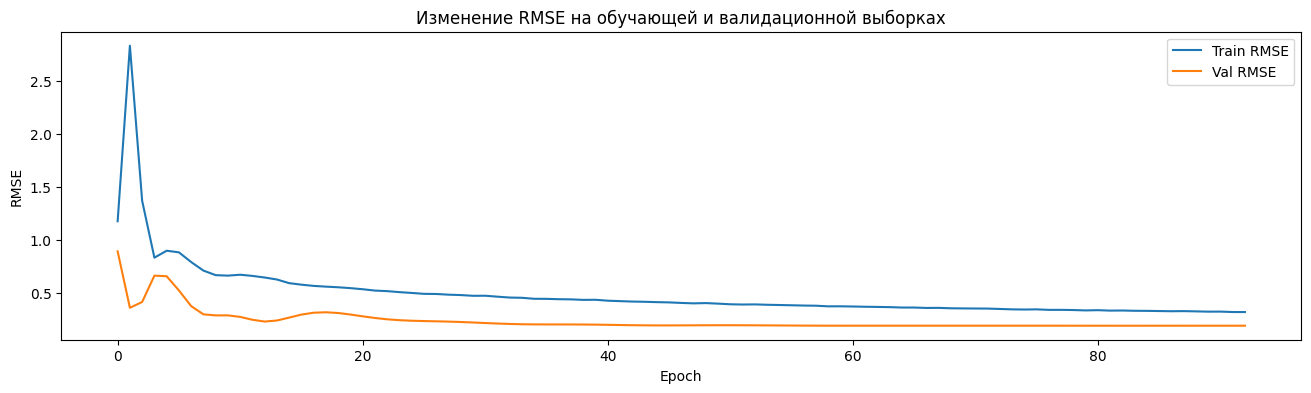

In [106]:
plt.figure(figsize=(16, 4))
plt.plot(train_rmse_list, label='Train RMSE')
plt.plot(val_rmse_list, label='Val RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('Изменение RMSE на обучающей и валидационной выборках')
plt.legend()
plt.show()


<img src="https://emojigraph.org/media/apple/check-mark-button_2705.png" align=left width=33, heigth=33>
<div class="alert alert-success">


Для осознанной настройки нейронки важно понимать, как менять её архитектуру (усложнять и уменьшать регуляризацию? уменьшать шаг обучения? усиливать регуляризацию?). Для того чтобы принять эти  решения мало видеть только конечную цифру, важно понимать, чего модели не хватает чтобы метрика стала лучше.
    
    
Вот типичные  проблемы, которые можно выявить  анализируя графики и пути их решения:

<b>Недообучение (Underfitting)</b>
  Признаки: Высокие значения потерь и низкая точность как на обучающей, так и на валидационной выборке. Графики потерь не снижаются (или снижаются  недостаточно).
  
  Решения:
    
 - Увеличение сложности модели (добавление слоев, увеличение числа нейронов).
 - Использование более сложных моделей, таких как более глубокие нейронные сети.
 - Увеличение количества эпох обучения.

<b>Переобучение (Overfitting)</b>
  Признаки: Значительное снижение потерь и увеличение точности на обучающей выборке, но высокие потери и низкая точность на валидационной выборке. Графики начинают расходиться после некоторого количества эпох.
    
 Решения:
  - Регуляризация (L1, L2 регуляризация).
  - Dropout (добавление Dropout слоев).
  - Уменьшение сложности модели (уменьшение числа слоев или нейронов).
  - Использование аугментации данных для увеличения разнообразия данных.
  - Раннее завершение обучения (Early Stopping) на основе валидационной ошибки.

<b>Плохой выбор гиперпараметров</b>
 Признаки: Нестабильные графики потерь и точности (большие колебания).
 
 Решения:
  - Настройка скорости обучения (learning rate).
  - Оптимизация размера батча (batch size).
  - Попробовать другие оптимизаторы (например, Adam, SGD с различными параметрами).    

</div>

### Вывод
Для разделения данных по image использовали метод GroupShuffleSplit, изображения из тренировочной и валидационной выборки не пересекались.

Данные отмасштабированы. Для оценки модели была выбрана метрика RMSE.

**DummyRegressor()** уступил нашей нейросеть с увеличенным числом слоев, batch нормализацией и регуляризацией dropout.
Метрика нейросети **RMSE = 0.191** (против 0.197 у dummy). 

Для получения метрики на тестовых изображениях будем использовать собранную нами **нейросеть**, с тремя скрытыми слоями, Batch Normalization, Dropout и SiLU для улучшения обучения и предотвращения переобучения.

## 7. Тестирование модели

Для проверки выбранной модели на тестовых данных, нам нужно будет самим определить, насколько хорошо подходит описание из `test_queries.csv` фотографии из `test_images`.

* Напишем функцию, которая принимает на вход текстовое описание, делает его векторизацию и возвращает картинку с максимальным значением метрики.
💡 Если запрос ведёт на юридически вредный контент, функция должна выводить дисклеймер.
* С помощью написанной вами функции протестируем работу модели на нескольких текстовых описаниях: какие картинки она выдает при различных текстовых запросах.

In [107]:
test_images.head(3)

,image
0,3356748019_2251399314.jpg
1,2887171449_f54a2b9f39.jpg
2,3089107423_81a24eaf18.jpg


In [108]:
test_image_path = "to_upload/test_images/"

In [109]:
test_images['image_path'] = test_image_path + test_images['image']

test_image_paths = test_images['image_path'].tolist()

In [110]:
test_dataset = ImageDataset(test_image_paths, preprocess)

In [111]:
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0 )

In [112]:
test_features_list = []

In [113]:
with torch.no_grad():
    for batch in tqdm(test_dataloader, desc="Векторизация тестовых изображений", ncols=100, leave=True):
        batch = batch.to(device)
        features = resnet(batch).view(batch.size(0), -1)
        test_features_list.append(features.cpu())

test_image_vectors = torch.cat(test_features_list).numpy()
test_images['image_vector'] = list(test_image_vectors)

print(test_image_vectors.shape)

Векторизация тестовых изображений: 100%|██████████████████████████████| 7/7 [00:01<00:00,  5.23it/s]

(100, 512)


In [114]:
# test_images['image_vector'] = test_images['image_path'].progress_apply(load_image).apply(resnet_forward)

# test_image_vectors = np.stack(test_images['image_vector'])

# test_image_vectors.shape

In [115]:
def clear_lower_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z ]', ' ', text)
    return " ".join(text.split())

In [116]:
def find_image(index):
    # 1. Текст очищаем от знаков, лемматизируем
    query_text_clean = clear_lower_text(test_queries.loc[index, 'query_text'])
    query_text_ready = lemmatize(query_text_clean)

    # 2. Проверяем запрещенные слова
    if any(word in query_text_ready for word in child_words):
        print('########################################################################')
        print('This image is unavailable in your country in compliance with local laws.')
        print('########################################################################')
        return

    # 3. Получаем вектор описания
    #query_vector = tf_idf.transform([query_text_ready]).toarray().flatten()
    query_vector = get_bert_embbedding(query_text_ready).reshape(1, -1)
    
    # дублируем вектор, чтобы он соответствовал размеру test_image_vectors
    query_vector = np.tile(query_vector, (test_image_vectors.shape[0], 1))
    
    # 4. Объединяем 
    X_vector = np.hstack((test_image_vectors, query_vector))

    # 5. Преобразуем в тензор для нейросети
    X_tensor = torch.tensor(X_vector, dtype=torch.float32).to(device)

    # 6. Получаем предсказания от нейросети
    extended_net.eval()
    with torch.no_grad():
        proba = extended_net(X_tensor).cpu().numpy().flatten()

    # 7. Сортируем предсказания и выбираем топ
    top_indices = np.argsort(proba)[::-1][:10]
    top_images = pd.DataFrame({'image': test_queries.loc[top_indices, 'image'], 
                               'proba': proba[top_indices]})

    # 8. 
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.ravel()
    
    for i, idx in enumerate(top_indices):
        img = Image.open(test_image_path + test_queries.loc[idx, 'image'])
        axes[i].imshow(img)
        axes[i].set_title(f"Probability: {proba[idx]:.2f}")
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()
    
    return top_images[["image", "proba"]]

In [117]:
 test_queries.sample(5)

,query_id,query_text,image
237,3122579598_14841c038a.jpg#2,Two children play with a white dog .,3122579598_14841c038a.jpg
331,3435015880_eda46ff50f.jpg#1,A man and a woman are running and jumping on t...,3435015880_eda46ff50f.jpg
484,957682378_46c3b07bcd.jpg#4,Two dogs are wrestling in the park .,957682378_46c3b07bcd.jpg
385,3520936130_9e90872560.jpg#0,A man and a woman are sitting on a bench outsi...,3520936130_9e90872560.jpg
238,3122579598_14841c038a.jpg#3,Two children stand in the grass while a white ...,3122579598_14841c038a.jpg


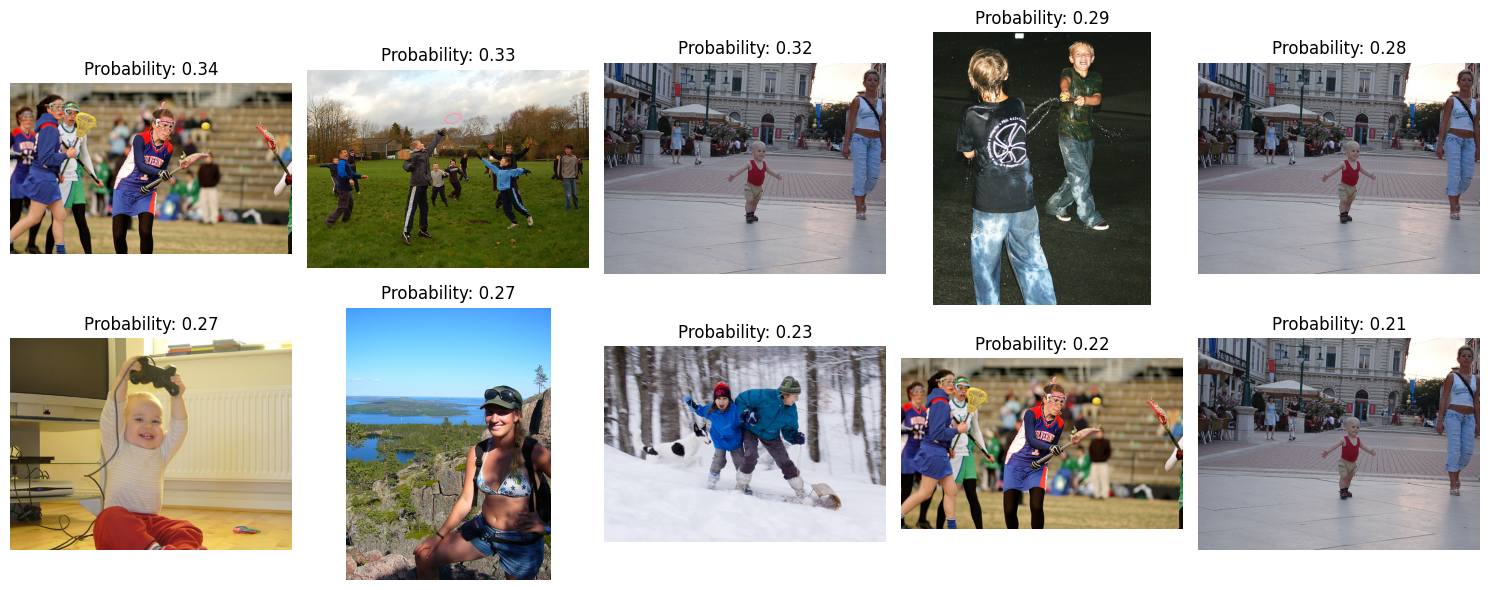

,image,proba
12,123997871_6a9ca987b1.jpg,0.344051
66,2121140070_a09644550b.jpg,0.325424
47,191003283_992257f835.jpg,0.319703
0,1177994172_10d143cb8d.jpg,0.288649
49,191003283_992257f835.jpg,0.282279
58,2060031241_a3ae7a06bb.jpg,0.270204
42,186346360_541047336f.jpg,0.268183
72,2141713971_e25eb12712.jpg,0.233144
10,123997871_6a9ca987b1.jpg,0.221433
46,191003283_992257f835.jpg,0.212830


In [121]:
# в функцию вывода подходящих изображений можно ввести индекс описания из test_queries выше
find_image(331)

<img src="http://s3.amazonaws.com/pix.iemoji.com/images/emoji/apple/ios-12/256/waving-hand.png" align=left width=44, heigth=44>
<div class="alert alert-info">
<b> Идеи и альтернативные подходы</b>
  Если хочешь получить хорошо работающее решение без обучения, то можешь провести эксперимент с нейронной сетью CLIP от OPEN AI (это не обязательно, только если хочешь добиться хороших результатов в этом проекте).

  Про эту нейронку много где написано, но можешь посмотреть например вот здесь  https://habr.com/ru/post/539312/.

  А для написания  реализации наиболее удобной лично для меня оказалась библиотека sbert. https://www.sbert.net/examples/applications/image-search/README.html  
    
    
<hr>    
    
Также неплохо работает следующий подход без предобученных моделей (к тому же легко реализуемый).
    
    
Вместо того, чтобы подавать на вход модели изображение + текст и получать меру соответствия, поступаем по другому. 
    
На вход модели подаем вектор описания, а на выходе учимся предсказывать вектор изображения. 
    
По поводу метрик тут ситуация следующая. Точно работает следующий подход
    
  - берем метрику mse, но тогда нужно чтобы модель её уменьшала. А значит в обучении используем только пары заведомо сответствующие друг другу

Можно попробовать использовать косинусное расстояние, она позволяет использовать все данные (если есть соответствие то выдает 1, если нет то 0). 
    
Также можно попробовать усложнить модель, например и изображения и тексты отправлять в пространство размерностью 256 и уже в этом пространстве учиться их "сближать".
    
По поводу методов векторизации: я бы использовать resnet18 для изображений (размерность эмбеддинга избражения 512) и БЕРТ для текстов (768). 
    
   
</div>

### CLIP

In [119]:
model = open_clip.create_model('ViT-B-32', pretrained='openai')
model.to(device)

C:\Users\User\anaconda3\envs\tf_gpu\lib\site-packages\open_clip\factory.py:388: UserWarning: These pretrained weights were trained with QuickGELU activation but the model config does not have that enabled. Consider using a model config with a "-quickgelu" suffix or enable with a flag.
  warnings.warn(


CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (patch_dropout): Identity()
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): ModuleList(
        (0-11): 12 x ResidualAttentionBlock(
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ls_1): Identity()
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): GELU(approximate='none')
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ls_2): Identity()
        )
      )
    )
    (ln_post): LayerNorm((768,), eps=1e-05, elementwise_affine

In [120]:
preprocess = open_clip.image_transform(model.visual.image_size, is_train=False)

In [109]:
tokenizer = open_clip.get_tokenizer('ViT-B-32')

In [124]:
def encode_images(image_paths, model, preprocess, device):
    image_tensors = []

    for path in tqdm(image_paths, desc="Векторизация изображений"):
        image = Image.open(path).convert("RGB")
        image = preprocess(image).unsqueeze(0).to(device)
        image_tensors.append(image)

    image_tensors =torch.cat(image_tensors)

    with torch.no_grad():
        image_features = model.encode_image(image_tensors)

    return image_features.cpu().numpy()

In [125]:
test_image_vectors_clip = encode_images(test_images['image_path'], 
                                        model, 
                                        preprocess, 
                                        device)

Векторизация изображений: 100%|██████████| 100/100 [00:01<00:00, 72.32it/s]


In [126]:
def encode_text(text, model, tokenizer, device):
    tokens = tokenizer(text).to(device)
    
    with torch.no_grad():
        text_features = model.encode_text(tokens)
        
    return text_features.cpu().numpy()

In [127]:
def find_similar_images(query_text, image_vectors, models, tokenizer, device, top_k=10):
    query_vector = encode_text(query_text, model, tokenizer, device)
    similarities = cosine_similarity(query_vector, image_vectors)[0]

    top_indices = similarities.argsort()[::-1][:top_k]
    return test_images.iloc[top_indices][['image_path']], similarities[top_indices]

In [128]:
 test_queries.sample(5)

,query_id,query_text,image
396,3555573680_41c1540a86.jpg#1,A man is doing a jump on a wakeboard in the wa...,3555573680_41c1540a86.jpg
2,1177994172_10d143cb8d.jpg#2,Two boys spraying each other with water,1177994172_10d143cb8d.jpg
401,3601978895_9fec23ce0c.jpg#1,Two men are standing under a large work of art...,3601978895_9fec23ce0c.jpg
27,1468389504_c724bdcad0.jpg#2,Two little girls in pink outfits play on a yel...,1468389504_c724bdcad0.jpg
116,2461990494_c5ece064cc.jpg#1,A man wearing a backpack looking to the side .,2461990494_c5ece064cc.jpg


In [130]:
num = 396
query =  test_queries['query_text'][num]

query

'A man is doing a jump on a wakeboard in the water .'

In [131]:
top_images, scores = find_similar_images(query, test_image_vectors_clip, model, tokenizer, device)

print(top_images)

TypeError: embedding(): argument 'indices' (position 2) must be Tensor, not BatchEncoding

## 8. Выводы


Мы разработали модель для поиска фотографий на фотохостинге по описанию.

Модель получаем векторное представление изображения, которое мы делаем с помощью сверточной нейросети ResNet-18.

Тексты описания предварительно проверяются на содержание слов, чтобы не выводить изображения запрещенные законодательством. Тексты подготавливаются и векторизуются с помощью векторизатора TF_IDF.

Две модели были опробованы на валидационной выборке. Для оценки модели была выбрана метрика RMSE.

**Нейросеть**, с тремя скрытыми слоями, Batch Normalization, Dropout и SiLU, показала метрику **RMSE = 0.191**. Она была выбрана для тестирования на избранных фотографиях. 

Для тестирования создали функцию, которая:
1. принимала текст описания фото
2. подготавливала и векторизировала текст
3. объединяла с векторами тестовых изображений
4. искала вероятности совпадения с помощью выбранной нейросети.

Однако на тестовых данных алгоритм не показал высокой вероятности совпадения и требует доработки.

<img src="http://s3.amazonaws.com/pix.iemoji.com/images/emoji/apple/ios-12/256/waving-hand.png" align=left width=44, heigth=44>
<div class="alert alert-info">
<b> Заключительный комментарий</b>

Подведем итоги. Я вижу, что в целом с проектом ты справляешься.
    
Проведено исследование и предобработка данных. Выполнена векторизация изображений и текстовых описаний. Обучены модели для предсказания степени соответствия, а также написана функция для инференса и с её помощью проведено тестирование.
 
    
Очень растроило использование дамми-модели на этапе тестирования. 
    
    
Желтые комментарии на твое усмотрение. Но учитывая что наш подход "не взлетел" и нужно хоть что-то показать заказчику, попробуй показать возможный инференс с помщью CLIP. С библиотекой sentence-transformers это делается буквально в 10 строк.    
Жду твою работу на повторное ревью.
</div>